# Day and Night Image Classifier

The day/night image dataset consists of 200 RGB color images in two categories: day and night. There are equal numbers of each example: 100 day images and 100 night images.

A classifier that can accurately label these images as day or night, and that relies on finding distinguishing features between the two types of images。

In [29]:
# import resources
import cv2 # computer vision library
import helpers

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

### Training and Testing Data
The 200 day/night images are separated into training and testing datasets. 

* 60% of these images are training images, for you to use as you create a classifier.
* 40% are test images, which will be used to test the accuracy of your classifier.

In [30]:
# Create directories for training image data
image_dir_training = "images/day_night_images/training/"

# NOT "Image Processing/images/day_night_images/training/"

# Create directories for test image data
image_dir_test = "images/day_night_images/test/"

### Load the datasets

These first few lines of code will load the training day/night images and store all of them in a variable, `IMAGE_LIST`. This list contains the images and their associated label ("day" or "night"). 

For example, the first image-label pair in `IMAGE_LIST` can be accessed by index: 
``` IMAGE_LIST[0][:]```.

In [31]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST = helpers.load_dataset(image_dir_training) # a list of tuples
print('Number of images:', len(IMAGE_LIST))
print(IMAGE_LIST[0][0].shape) # image
print(IMAGE_LIST[0][1]) # label

Number of images: 240
(458, 800, 3)
day


### Visualize the input images

Shape: (458, 800, 3)
Label: day


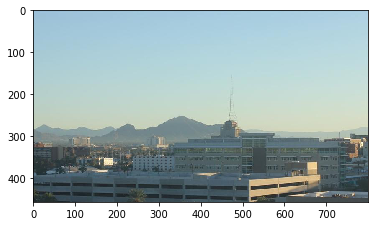

In [32]:
# Select an image and its label by list index
image_index = 0
selected_image = IMAGE_LIST[image_index][0]
selected_label = IMAGE_LIST[image_index][1]

# Display image and data about it
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label: " + str(selected_label))

### Pre-process the input data

(600, 1100, 3)

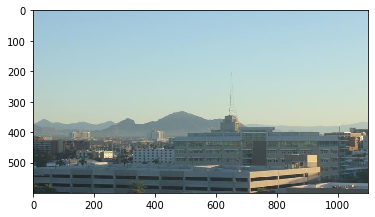

In [33]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    ## TODO: Resize image so that all "standard" images are the same size 600x1100 (hxw) 
    #standard_im = []
    dim = (1100, 600) # height x width
    standard_im = cv2.resize(image, dim)
    return standard_im

resized = standardize_input(selected_image)
plt.imshow(resized)
resized.shape

### Standarize the output with binary encoding
With each loaded image, specify the expected output. 
Use binary numerical values 0/1 = night/day.

In [34]:
# encode("day") should return: 1
# encode("night") should return: 0

def encode(label):
        
    if label == "day":
        return 1
    elif label == "night":
        return 0

### Construct a `STANDARDIZED_LIST` of input images and output labels.

In [35]:
def standardize(image_list):
    standard_list = []
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # Create a numerical label
        binary_label = encode(label)    

        # Append the image
        standard_list.append((standardized_im, binary_label))
        
    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

### Visualize the standardized data

Shape: (600, 1100, 3)
Label [1 = day, 0 = night]: 1


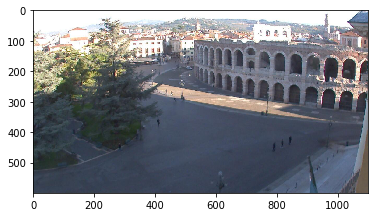

In [36]:
# Display a standardized image and its label

# Select an image by index
image_num = 50
selected_image = STANDARDIZED_LIST[image_num][0]
selected_label = STANDARDIZED_LIST[image_num][1]

# Display image and data about it
## TODO: Make sure the images have numerical labels and are of the same size
plt.imshow(selected_image)
print("Shape: "+str(selected_image.shape))
print("Label [1 = day, 0 = night]: " + str(selected_label))

## Feature Extraction

Create a feature that represents the brightness in an image. Extract the **average brightness** using HSV colorspace. Specifically, add up the pixel values in the V channel(a measure of brightness), then divide that sum by the area of the image to get the average Value of the image.

### RGB to HSV conversion

Below, a test image is converted from RGB to HSV colorspace and each component is displayed in an image.

Label: 1


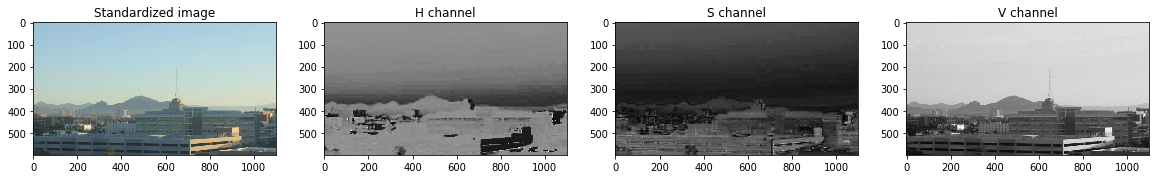

In [37]:
# Convert and image to HSV colorspace
# Visualize the individual color channels

image_num = 0
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

# Convert to HSV
hsv = cv2.cvtColor(test_im, cv2.COLOR_RGB2HSV)

# Print image label
print('Label: ' + str(test_label))

# HSV channels
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

# Plot the original image and the three channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.set_title('Standardized image')
ax1.imshow(test_im)
ax2.set_title('H channel')
ax2.imshow(h, cmap='gray')
ax3.set_title('S channel')
ax3.imshow(s, cmap='gray')
ax4.set_title('V channel')
ax4.imshow(v, cmap='gray')


###  Find the average brightness using the V channel

In [38]:
# Find the average Value or brightness of an image
def avg_brightness(rgb_image):
    
    # Convert image to HSV
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)

    # Add up all the pixel values in the V channel
    sum_brightness = np.sum(hsv[:,:,2])
    
    ## Calculate the average brightness
    area = rgb_image.shape[0] * rgb_image.shape[1]
    avg = sum_brightness / area
    
    return avg

Average brightness: 142.13570757575758


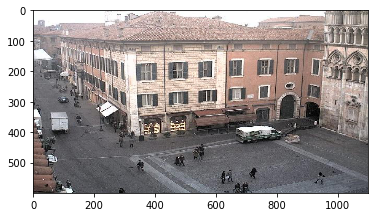

In [39]:
# Testing average brightness levels
image_num = 119
test_im = STANDARDIZED_LIST[image_num][0]

avg = avg_brightness(test_im)
print('Average brightness: ' + str(avg))
plt.imshow(test_im)

### Calculate day and night brightness threshold

In [40]:
# Day
s_day = 0
for i in range(120):
    avg = avg_brightness(STANDARDIZED_LIST[i][0])
    s_day += avg
print("Average Brightness for day:", s_day/120)

# Night 
s_night = 0
for i in range(120, 240):
    avg = avg_brightness(STANDARDIZED_LIST[i][0])
    s_night += avg
print("Average Brightness for night:", s_night/120)

Average Brightness for day: 137.37790688131312
Average Brightness for night: 69.20089227272726


## Classifier

Turn average brightness feature into a classifier that takes in a standardized image and returns a `predicted_label` for that image. This `estimate_label` function should return a value: 0 or 1 (night or day, respectively).

In [41]:
def estimate_label(rgb_image):
    avg = avg_brightness(rgb_image)
    
    # Use the avg brightness feature to predict a label (0, 1)
    threshold = (137.37790688131312 + 69.20089227272726) / 2
    if avg < threshold:
        return 0 # night
    else:
        return 1 # day

### Compute accuracy

In [44]:
correct = 0
incorrect = 0
incorrect_idx = []
for i in range(240):
    label = STANDARDIZED_LIST[i][1]
    predict = estimate_label(STANDARDIZED_LIST[i][0])
    if label == predict:
        correct += 1
    else:
        incorrect += 1
        incorrect_idx.append(i)

accuracy = correct / (correct + incorrect)

In [45]:
print("The accuracy for this classifier is:", accuracy)

The accuracy for this classifier is: 0.9166666666666666


In [46]:
print(incorrect_idx)

[71, 74, 82, 138, 142, 146, 149, 152, 154, 155, 156, 157, 158, 160, 162, 164, 165, 167, 170, 173]


Examples of misclassified images:


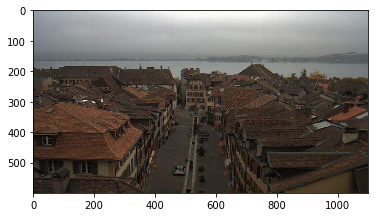

In [49]:
print("Examples of misclassified images:")
plt.imshow(STANDARDIZED_LIST[71][0])

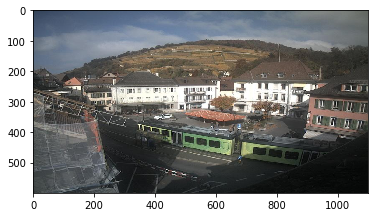

In [50]:
plt.imshow(STANDARDIZED_LIST[82][0])

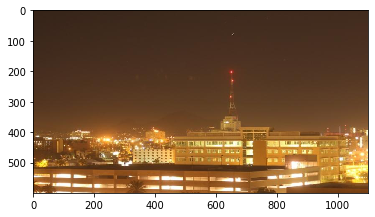

In [51]:
plt.imshow(STANDARDIZED_LIST[158][0])